# Homework 4

In [1]:
import EoN as eon
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [4]:
# Read the graph
G = nx.read_edgelist("./fludata.txt", nodetype=int, data=(('interactions',int),))

In [5]:
N = G.number_of_nodes()
degrees = nx.degree(G)

## Part 1

### A) Plot Infected Individuals Over Time

In [2]:
tmax = 10
beta = 0.01      # transmission rate
mu = 0.5         # recovery rate
initial_infected = 325

In [6]:
# run 10 simulations and plot the number of infected over time
# result = [eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=initial_infected, tmax=tmax) for _ in range(10)]

result = Parallel(n_jobs=-1)(delayed(eon.fast_SIS)(G, tau=beta, gamma=mu, initial_infecteds=initial_infected, tmax=tmax) for _ in range(10))

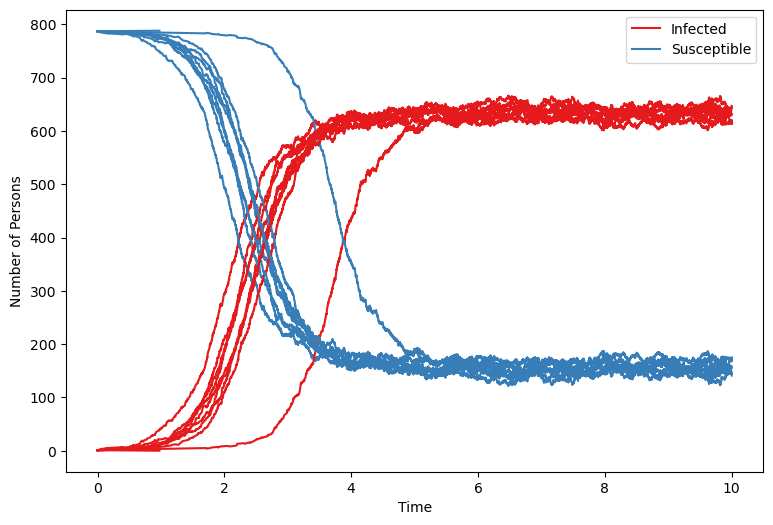

In [8]:
cmap = cm.get_cmap('Set1')
plt.figure(figsize=(9, 6))
for i, (t, S, I) in enumerate(result):
    # just label the first simulation
    plt.plot(t, I, c=cmap(0), label="Infected" if i == 0 else None)
    plt.plot(t, S, c=cmap(1), label="Susceptible" if i == 0 else None)
plt.xlabel("Time")
plt.ylabel("Number of Persons")
plt.legend();

**Commentary**:Both infected and susceptible number of infections follow a logistic curve.There is an inverse relationship between the number of infected persons (in red) and that of susceptible persons (in blue). From the plot we observe that susceptible number starts at a maximum (about 800), stabilizes at about 1.5 time step after which it begins to drop sharply (exponential regime) to about the 2.5 time step. The number of susceptible persons start to stabilize (saturation regime) to about 200 persons throughout the rest of the period. The number of infected persons behave the exact opposite of the susceptible persons, with the number of infected persons been low in the beginning and rising sharply (exponential regime) to only stabilize at a high number (exponential regime) throughout the remainder of the period. Intuitively, the susceptible persons are been infected by the pathogen until a considerable amount of the population has been infected.With time an infected individual encounters fewer susceptible individuals and hence the growth of infection slows as time progresses.

---
### B) Actual VS Estimated Infected

In [9]:
def infections_over_time(t, tau):
    i0 = 1
    return i0 * np.exp(t/tau)

In [9]:
# Compute τ from simulations
while True:
    t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=initial_infected, tmax=tmax)
    if I[-1] == 0:
        continue
    break
# get only exponential part I(t)<= 100
for idx, i in enumerate(I):
    if i >= 100:
        break
t = t[:idx]
S = S[:idx]
I = I[:idx]

In [10]:
popt, pcov = curve_fit(infections_over_time, xdata=t, ydata=I)
estimated_tau = popt[0]
I_hat = infections_over_time(t, estimated_tau)
estimated_tau

0.3767377456884715

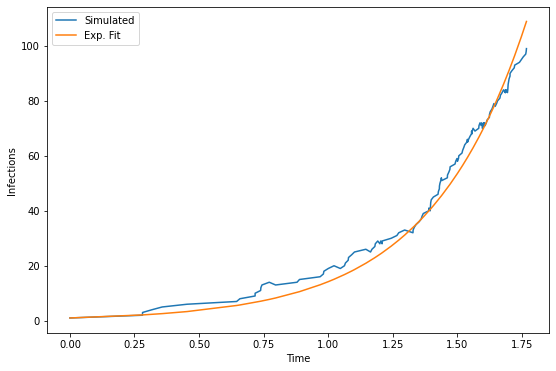

In [11]:
# Plot the actual number of infected and the exponential fit computed
plt.figure(figsize=(9, 6))
plt.plot(t, I, label="Simulated")
plt.plot(t, I_hat, label="Exp. Fit")
plt.xlabel("Time")
plt.ylabel("Infections")
plt.legend();

In [12]:
# quantify closeness
r2_score(I, I_hat)

0.97473537857713

---
### C) Simulated VS Theoretical Estimates of $\tau$

In [32]:
# Run several times (25x or more) to compute distribution of tau
tau_estimations = []
trials = 25
while trials > 0:
    t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=initial_infected, tmax=tmax)
    if I[-1] == 0:
        continue
    trials -= 1
    # get only exponential part I(t)<= 100
    for idx, i in enumerate(I):
        if i > 100:
            break
    t = t[:idx]
    S = S[:idx]
    I = I[:idx]
    # estimate tau
    popt, pcov = curve_fit(infections_over_time, xdata=t, ydata=I)
    estimated_tau = popt[0]
    tau_estimations.append(estimated_tau)

Manually compute the theoretical values of tau here (include the formula and your results):

**For random distribution from Canvas:**

$$\tau=\frac{1}{\bar{k}\beta-\mu} $$ $$ \bar{k} = \frac{2m}{n}$$

In [89]:
# calculate random distribution
# k_bar = np.mean(list(dict(degrees).values()))
m = G.number_of_edges()
n = G.number_of_nodes()
k_bar_rand = 2 * m / n
random_distribution_from_canvas = 1/(k_bar_rand*beta-mu)
random_distribution_from_canvas

0.3996307979430171

**For arbitrary distribution from Canvas:**
$$\tau = \frac{\bar{k}}{\beta{\bar{k}^2}-(\beta + \mu){\bar{k}}}$$

\begin{equation}
 \overline{k^2}=\sum_k k^2 p_k
\end{equation}

In [90]:
from collections import Counter
k_dict = Counter(dict(degrees).values())
for k, c in k_dict.items():
    k_dict[k] = c/n # pk

In [91]:
k_bar_arb = sum([k*pk for k, pk in k_dict.items()])
k2_bar_arb = sum([k**2*pk for k, pk in k_dict.items()])
k_bar_arb, k2_bar_arb


(300.2309644670049, 100805.69796954312)

In [68]:
# make sure that k_bar is the average degree
assert abs(np.mean(list(dict(degrees).values())) - k_bar) < 1e-3

In [92]:
# calculate arbitrary distribution (from Canvas)

arbitrary_distribution_from_canvas = k_bar_arb / ((beta * k2_bar_arb) - ((beta + mu)* k_bar_arb))
arbitrary_distribution_from_canvas

0.3511723041185224

**For arbitrary distribution in textbook**

\begin{equation}
\frac{\langle k\rangle}{\beta\left\langle k^2\right\rangle-\mu\langle k\rangle}
\end{equation}

In [93]:
# calculate arbitrary distribution (from textbook)

# arbitrary_distribution_from_textbook = 0.35 # todo
arbitrary_distribution_from_textbook = k_bar_arb / ((beta * k2_bar_arb)-(mu * k_bar_arb))
arbitrary_distribution_from_textbook

0.3499433998182699

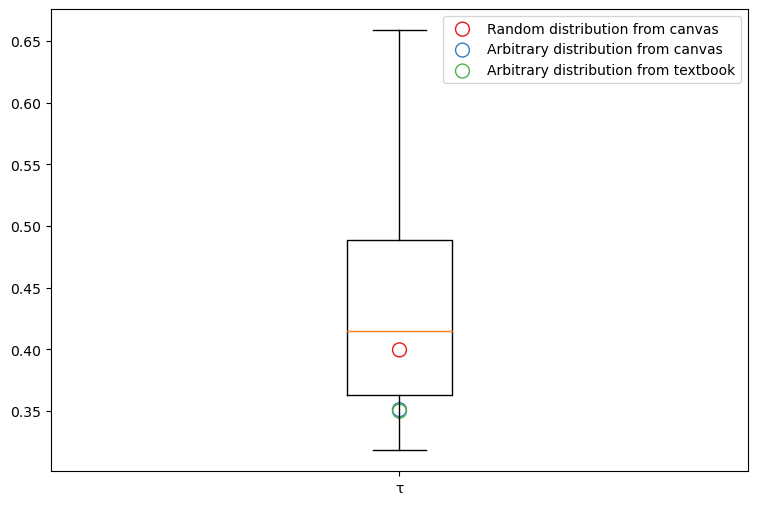

In [75]:
# Plot the experimental distribution (box plot would be preferred) and theoretical values

plt.figure(figsize=(9, 6))
plt.boxplot(tau_estimations)
plt.scatter([1], [random_distribution_from_canvas], label="Random distribution from canvas", s=100, facecolors='none', edgecolors=cmap(0))
plt.scatter([1], [arbitrary_distribution_from_canvas], label="Arbitrary distribution from canvas", s=100,facecolors='none', edgecolors=cmap(1))
plt.scatter([1], [arbitrary_distribution_from_textbook], label="Arbitrary distribution from textbook", s=100,facecolors='none', edgecolors=cmap(2))
plt.xticks([1], labels=["τ"])
plt.legend();

Which distributions match your simulation results most accurately?

**The random distribution estimation of tau matches the simulated tau most accurately.**

---
### D) Infection at the Endemic State

Compute the theoretical expected value of $i(\infty)$:


In [34]:
simulations = Parallel(n_jobs=-1)(delayed(eon.fast_SIS)(G, tau=beta, gamma=mu, initial_infecteds=initial_infected, tmax=tmax) for _ in range(200))
# filter out simulations with less than 100 timesteps
simulations = [s for s in simulations if len(s[0])>100]

In [35]:
def identify_endemic(I, window=100, threshold=10):
    for idx in range(len(I)-window):
        values = I[idx: idx+window]
        if max(values) - min(values) <= threshold:
            return idx
    return None

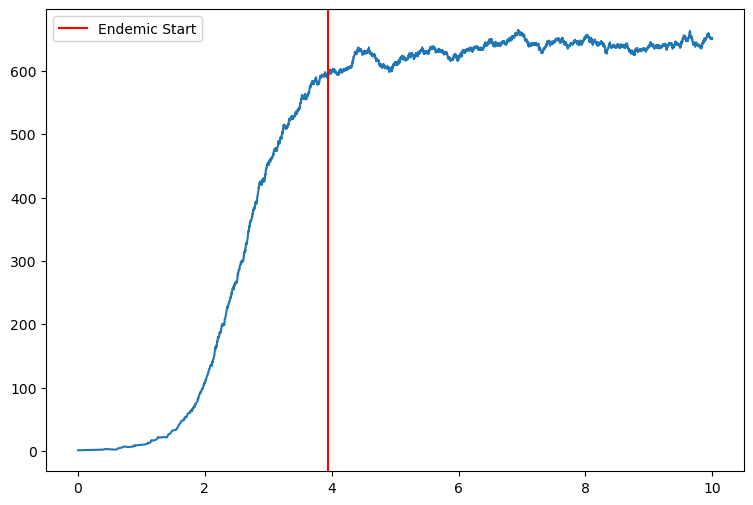

In [36]:
# testing identify_endemic function
t, S, I = simulations[0]
endemic_start = identify_endemic(I)
plt.figure(figsize=(9, 6))
plt.plot(t, I)
plt.axvline(t[endemic_start], label="Endemic Start", c='red')
plt.legend();

In [40]:
def get_I_inf(I):
    idx = identify_endemic(I)
    return np.mean(I[idx:])

In [41]:
# Compute the distribution of i(\inf)
i_inf_values = []
for t, S, I in simulations:
    i_inf_values.append(get_I_inf(I)/N)

In [76]:
β_theoretical = 1 - (mu / (k_bar * beta))

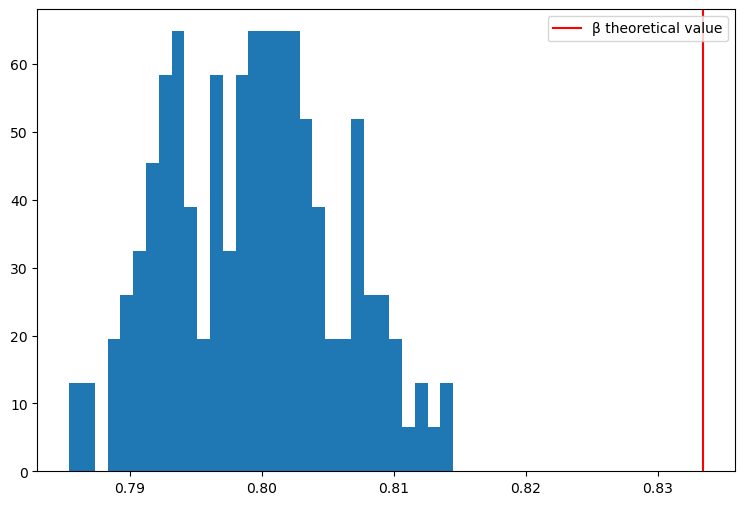

In [80]:
# Plot the experimental distribution of i(\inf) and theoretical value
# β_theoretical = 0.8 # TODO
plt.figure(figsize=(9, 6))
plt.hist(i_inf_values, bins=30, density=True)
plt.axvline(β_theoretical, c='red', label="β theoretical value")
plt.legend();

---
## Part 2

### A) Varying Transmission Rate $\beta$

In [44]:
mu = 0.5

In [176]:
# Run simulations by varying beta
def I_inf_vs_β(β):
    I_inf_values = []
    for i in range(10):
        t, S, I = eon.fast_SIS(G, tau=β, gamma=mu, initial_infecteds=initial_infected, tmax=tmax)
        I_inf_values.append(get_I_inf(I))
    return np.mean(I_inf_values)
        
β_range = np.arange(0.001, 0.105, 0.005)
# number of infected individuals at the endemic state for each β
I_inf_range = Parallel(n_jobs=-1)(delayed(I_inf_vs_β)(β) for β in β_range)

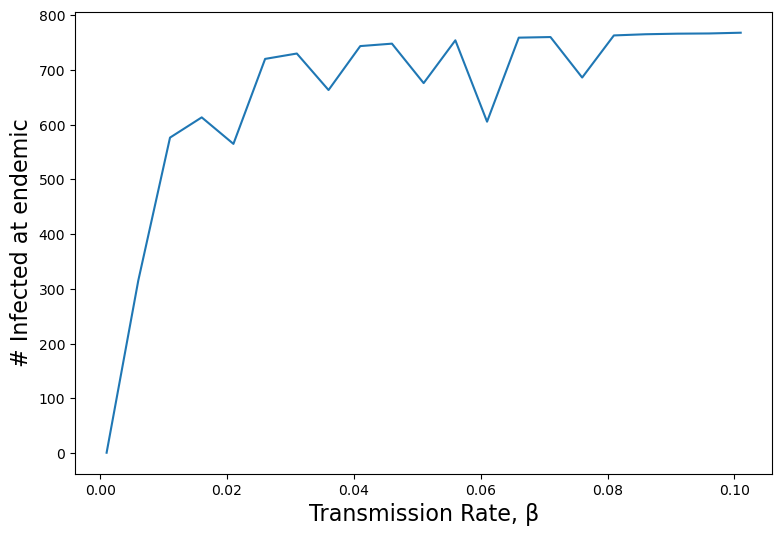

In [178]:
# Plot # infected individuals at the epidemic state vs beta
plt.figure(figsize=(9, 6))
plt.plot(β_range, I_inf_range)
plt.xlabel("Transmission Rate, β", fontsize=16)
plt.ylabel("# Infected at endemic", fontsize=16);

---
### B) Minimum Transmission Rate for Epidemic

Compute theoretical values for minimum $\beta$ required for epidemic to occur:

**Random distribution:**  
\begin{equation}
\frac{\beta}{\mu}>\frac{1}{\bar{k}}
\end{equation}


In [179]:
# for a random degree distribution
# this function returns only the lower bound as seen in the formula above
min_beta_rand = mu/k_bar_rand
min_beta_rand

0.0016653845178415938

**Arbitrary distribution:** 

\begin{equation}
\frac{\beta}{\beta+\mu}>\frac{\bar{k}}{\overline{k^2}}
\end{equation}

In [181]:
# for an arbitrary distribution
# this function returns only the lower bound as seen in the formula above
min_beta_arb = mu * (k_bar_arb / k2_bar_arb) / (1 - k_bar_arb/k2_bar_arb)
min_beta_arb

0.0014936051411603387

**Beta Theoretical And Experimental Calculation**

\begin{equation}
i(\infty)=(1-\frac{\mu}{\beta\langle k\rangle}) * N
\end{equation}

In [182]:
# theoretical number of infected individuals at endemic state

def calculate_I_inf_vs_β(β, k_bar):
    return (1 - (mu / (k_bar * β))) * N

In [184]:
# Compute the theoretical number of infected individuals with different betas as well as the simulation.
# random distribution
th_I_inf_range = Parallel(n_jobs=-1)(delayed(calculate_I_inf_vs_β)(β, k_bar_arb) for β in β_range)

floor number of infections at zero since the -524 ()derived from the theoretical) means that the epidemic dies out (k_bar*$\beta$<$\mu$)

In [203]:
th_I_inf_range[0] = 0.0 

# random distribution
th_rand_I_inf = calculate_I_inf_vs_β(min_beta_rand, k_bar_rand) # theoretical
sim_rand_I_inf = I_inf_vs_β(min_beta_rand) # simulation

th_rand_I_inf, sim_rand_I_inf

# arbit distribution
th_arbit_I_inf = calculate_I_inf_vs_β(min_beta_arb, k_bar_arb) # theoretical
sim_arbit_I_inf = I_inf_vs_β(min_beta_arb) # simulation

th_arbit_I_inf, sim_arbit_I_inf

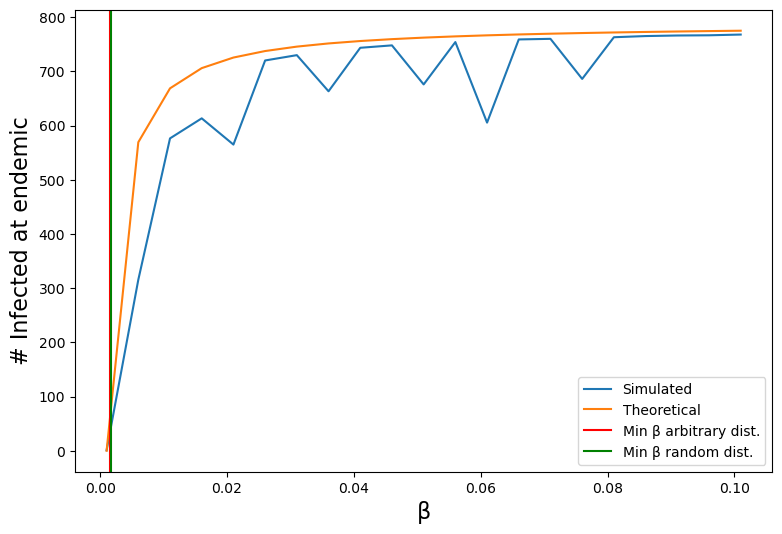

In [204]:
# Plot those two curves in one plot and compare them.
plt.figure(figsize=(9, 6))
plt.plot(β_range, I_inf_range, label="Simulated")
plt.plot(β_range, th_I_inf_range, label="Theoretical")
plt.axvline(min_beta_arb, label="Min β arbitrary dist.", c="r")
plt.axvline(min_beta_rand, label="Min β random dist.", c="g")
plt.xlabel("β", fontsize=16)
plt.ylabel("# Infected at endemic", fontsize=16);
plt.legend();

In [212]:
# Find min value of \beta experimentally
experimental_min_beta = min([(β,I) for β, I in zip(β_range, I_inf_range)])
experimental_min_beta

(0.001, 0.8311111111111111)

**Commentary**: The plot above shows that the theoretical and simulated infections at the endemic state follow a similar trend -- increasing number of infections as $\beta$ (transmission rate) increases. The minimum $\beta$ required for an epidemic too occur for the theoretical random distribution (0.0016), the theoretical arbitrary distribution (0.0015) and the experimental (0.0010) are surprisingly close. For the case of the theoretical values for both random and arbitrary distributions, it can also be seen from the plot above. The experimental minimum $\beta$ of 0.0010 corresponds to 0.831 infections which can be considered practically close to zero.

---
## Part 3

### A) Patient-0 Centrality & $\tau$

In [141]:
(N-1)/np.exp(1)

289.5211202019251

In [142]:
def compute_tau_from_simulation(t, I, S=N-1):
    threshold = S / np.exp(1)
    for time, i in zip(t, I):
        if i >= threshold:
            return time

In [143]:
# Run simulations with each node as initial infected and compute tau
def varying_initial_infected_node(node):
    taus = []
    for i in range(10):
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=node, tmax=tmax)
        if max(I)<(N-1)/np.exp(1):
            continue
        tau = compute_tau_from_simulation(t, I)
        taus.append(tau)
    return (node, np.mean(taus))

tau_dict = dict(Parallel(n_jobs=-1)(delayed(varying_initial_infected_node)(node) for node in G.nodes))

/Library/anaconda3/envs/graphnetwork/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/anaconda3/envs/graphnetwork/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/anaconda3/envs/graphnetwork/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/anaconda3/envs/graphnetwork/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [144]:
# Compute centrality metrics
deg_cent = nx.degree_centrality(G)
close_cent = nx.closeness_centrality(G)
btw_cent = nx.betweenness_centrality(G)
eig_cent = nx.eigenvector_centrality(G)

In [145]:
# align centrality metrics with tau values
tau_vals = []
deg = []
close = []
btw = []
eig = []
for k in tau_dict:
    if np.isnan(tau_dict[k]): # filter out nodes that didn't have a computed tau
        print(f"Could not compute tau for node {k}")
        continue
    tau_vals.append(tau_dict[k])
    deg.append(deg_cent[k])
    close.append(close_cent[k])
    btw.append(btw_cent[k])
    eig.append(eig_cent[k])

Could not compute tau for node 436
Could not compute tau for node 289
Could not compute tau for node 376


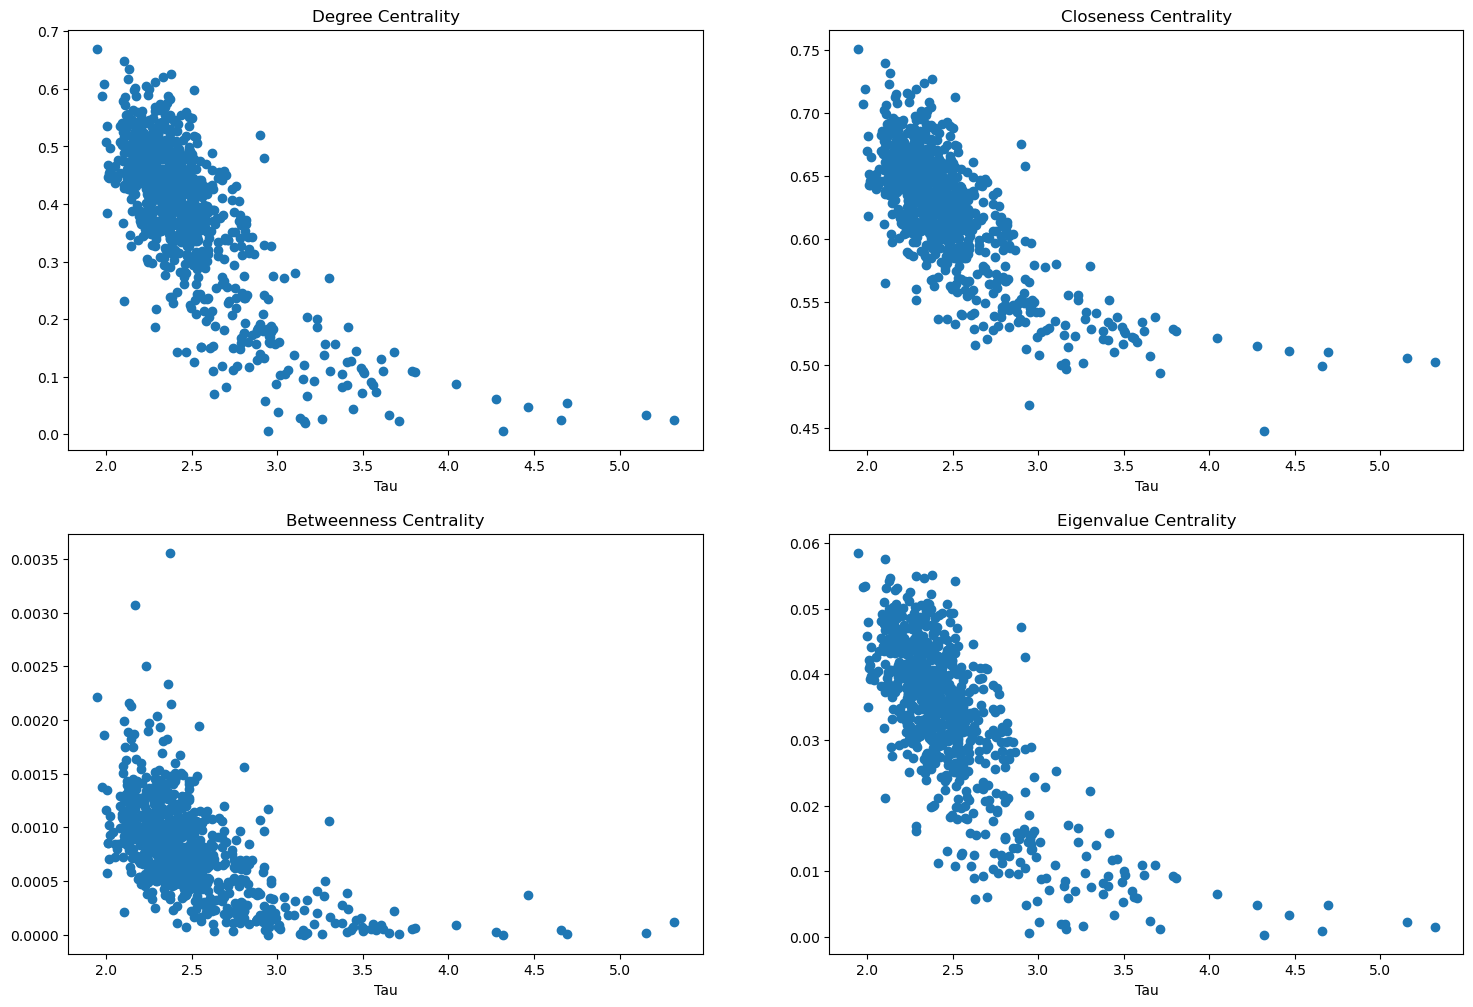

In [146]:
# Plot centrality metrics v/s tau - 4 plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
ax[0][0].scatter(tau_vals, deg)
ax[0][0].set_title("Degree Centrality")

ax[0][1].scatter(tau_vals, close)
ax[0][1].set_title("Closeness Centrality")

ax[1][0].scatter(tau_vals, btw)
ax[1][0].set_title("Betweenness Centrality")

ax[1][1].scatter(tau_vals, eig)
ax[1][1].set_title("Eigenvalue Centrality")

for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel("Tau")

---
### B) Correlation between centrality and $\tau$

In [147]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the 
    confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi, p

In [148]:
# Compute the Pearson correlation coefficient
for name, cent in zip(["Degree", "Closeness", "Betweenness", "Eigenvector"], [deg, close, btw, eig]):
    r, p, lo, hi, p = pearsonr_ci(tau_vals, cent)
    print(f"{name} Centrality:\tr={round(r, 4)}\tp_value={round(p, 4)}\t({round(lo, 4)}, {round(hi, 4)})")

Degree Centrality:	r=-0.7435	p_value=0.0	(-0.7732, -0.7105)
Closeness Centrality:	r=-0.7189	p_value=0.0	(-0.7511, -0.6833)
Betweenness Centrality:	r=-0.5576	p_value=0.0	(-0.604, -0.5074)
Eigenvector Centrality:	r=-0.7415	p_value=0.0	(-0.7714, -0.7083)


---
### C) Centrality as an Outbreak Predictor

The order here, from best to worst is:
**1. Degree**
**2. Eigen**
**3. Closeness**
**4. Betweenness**


**Commentary**: We compare the strength of above centrality metrics based on their absolute correlation values. Even though all 4 metrics are significant at 95% confidence level, we rank them based on their strongest correlation with the characteristic time, $\tau$. Since the characteristic time gives an idea of how fast an outbreak will spread through a system, a node with a higher degree (or contacts) will more likely spread the pathogen faster if they become infected. Therefore, the Degree centrality being the one with the highest correlation is intuitive in this case. Another metric -- Eigenvector Centrality -- which was the second strongest correlation is in order as well. A node is more central when its neighbor are central as well. Therefore, when a nodes with high influence is infected (a teacher), since they have other highly connected neighbors (another teacher collegue) they can pass along the pathogen quickly thereby increasing the spreading speed. We reason that such highly connected nodes would be the teachers who are the central piece of interaction within the network. Indeed, the difference between Eigenvector and Degree centrality is very minimal in this simulation suggesting that the two are most relevant to spread of a pathogen. 

Another observation worth mentioning is the least correlated metric -- Betweenness Centrality -- which represents how many paths to other nodes go throuugh a particular node. This metric is not very relevant to pathogen transfer via persons hence its low correlation with the characteristic time. It will be more application in other datasets in which a disease spreads through hubs such as major airports. In the flu data neither students nor teachers have to go through a particular person (node) to get to the other. 

## Part 4 - Knowledge Question

Your answer to the modularity proof food for thought here

Let $S$ be a set and $f: 2^S \mapsto \mathbb{R}$ be a function. Then $f$ is submodular iff it satisfies one of the following equivalent conditions:
1. $\forall R \subseteq S, \forall s_1 \notin R, \forall s_2 \notin R \cup\left\{s_1\right\}, f\left(R \cup\left\{s_1\right\}\right)+f\left(R \cup\left\{s_2\right\}\right) \geq f\left(R \cup\left\{s_1, s_2\right\}\right)+f(R)$.
2. $\forall Y \subseteq S, \forall X \subseteq Y, \forall Z \in S-Y, f(X \cup Z)-f(X) \geq f(Y \cup Z)-f(Y)$.
3. $\forall P \subseteq S, \forall Q \subseteq S, f(P)+f(Q) \geq f(P \cup Q)+f(P \cap Q)$
For any $X, Y \subseteq S$, the value of $f(X \cup Y)-f(X)$ is called the marginal of $Y$ over $X$ and is denoted by $f_X(Y)$.
Let $f$ and $g$ be submodular functions. Then $f+g$ is also submodular.
This result can be easily extended to positively weighted sum of multiple functions.
Proof
$$
\begin{aligned}
&(f+g)(P \cup Q)+(f+g)(P \cap Q) \\
&=(f(P \cup Q)+f(P \cap Q))+(g(P \cup Q)+g(P \cap Q)) \\
&\leq(f(P)+f(Q))+(g(P)+g(Q)) \\
&=(f+g)(P)+(f+g)(Q)
\end{aligned}
$$
Therefore, $f+g$ is also submodular.